# Web Scraping Nora Wiktorowicz Lab

We'll be scraping data about used appliances in Charlottesville from Craigslist, particularly this page: https://colab.research.google.com/github/norawik/wrangling/blob/main/lab/lab_notebook.ipynb#scrollTo=ymO8JbMmy3XY


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'}
url = 'https://charlottesville.craigslist.org/search/ppa?purveyor=owner#search=1~gallery~0~22'
raw = requests.get(url,headers=header)

Now that we have that particular page available locally, we want to **parse** it and get results from it. To do that, we can use a package called `beautifulSoup` or `bs4`.

The following code chunk takes the raw content from `requests` and turns it into a beautifulSoup object, which can search the page and return results for us:

In [2]:
from bs4 import BeautifulSoup as soup
bsObj = soup(raw.content,'html.parser')
listings = bsObj.find_all(class_="cl-static-search-result")

In [8]:
import re

brands = ['ge', 'elite gourmet','sanyo','maytag','electrolux','samsung','crockpot','frigidaire','kenmore','hunter',
          'dyson','american standard','bosch','oxo','sirman topaz','martin','vulcan','george forman','galanz',
          'nespresso','rinnai']


data = []
for k in range( len(listings) ):
    title = listings[k].find('div',class_='title').get_text().lower()
    price = listings[k].find('div',class_='price').get_text()
    link = listings[k].find(href=True)['href']

    words = title.split()
    hits = [word for word in words if word in brands]
    if len(hits) == 0:
        brand = 'missing'
    else:
        brand = hits[0]

    regex_search = re.search(r'20[0-9][0-9]|19[0-9][0-9]', title )
    if regex_search is None:
        year = np.nan
    else:
        year = regex_search.group(0)

    data.append({'title':title,'price':price,'link':link,'brand':brand})



With the data scraped from Craigslist, we can put it in a dataframe and wrangle it. Of course, price and year come in as text, not numbers, and need to be typecast/coerced:

In [9]:

df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
print(df.shape)
df.to_csv('./craigslist_cville_appliances.csv')
df.head()

(63, 4)


,title,price,link,brand
0,cast iron sink,225,https://charlottesville.craigslist.org/app/d/c...,missing
1,portable dishwasher must go this week,100,https://charlottesville.craigslist.org/app/d/l...,missing
2,3 in 1 cooker,30,https://charlottesville.craigslist.org/app/d/q...,missing
3,sanyo mini refrigerator,20,https://charlottesville.craigslist.org/app/d/q...,sanyo
4,deep freezer,100,https://charlottesville.craigslist.org/app/d/k...,missing


With the data in and wrangled, I would like to learn more about the breakdown of appliance prices and brands.

count      63.000000
mean      301.634921
std       616.801853
min         0.000000
25%        50.000000
50%       120.000000
75%       290.000000
max      4000.000000
Name: price, dtype: float64


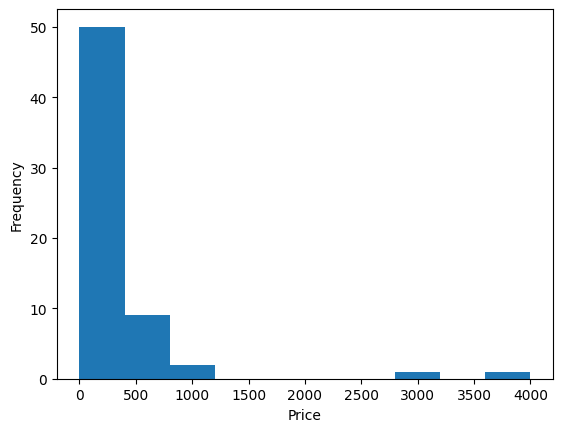

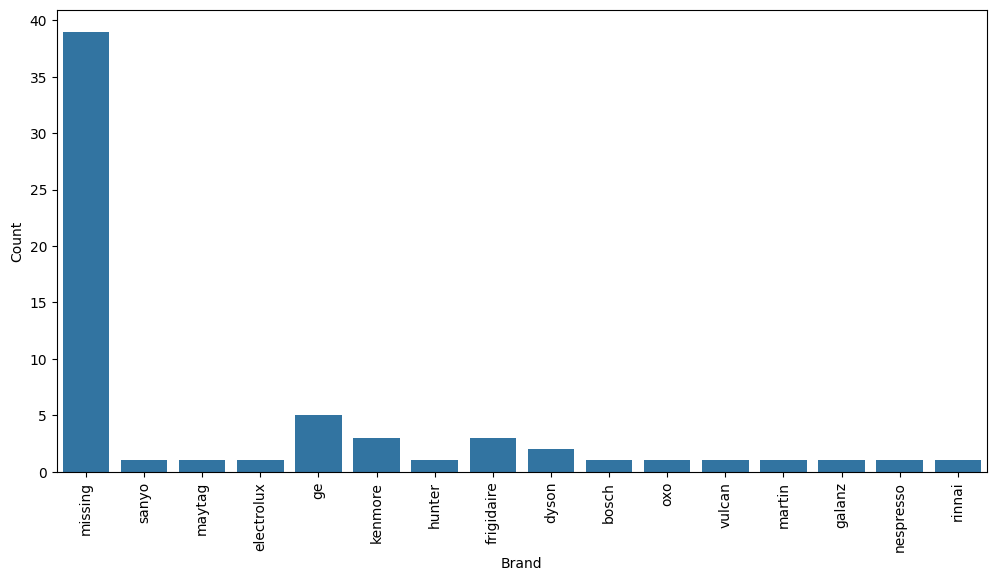

In [17]:
print(df['price'].describe())
df['price'].hist(grid=False)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='brand')
plt.xticks(rotation=90)
plt.xlabel('Brand')
plt.ylabel('Count')
plt.show()

Next, I would like to learn more about the breakdown of price by brand, to see how the appliance price varies based on brand name.

In [18]:
df.loc[:,['price','brand']].groupby('brand').describe()

price                                                             \
           count         mean         std     min      25%     50%      75%   
brand                                                                         
bosch        1.0   595.000000         NaN   595.0   595.00   595.0   595.00   
dyson        2.0    37.500000   17.677670    25.0    31.25    37.5    43.75   
electrolux   1.0   285.000000         NaN   285.0   285.00   285.0   285.00   
frigidaire   3.0   191.666667  137.689264   100.0   112.50   125.0   237.50   
galanz       1.0   125.000000         NaN   125.0   125.00   125.0   125.00   
ge           5.0   158.800000  105.639481    20.0   100.00   149.0   250.00   
hunter       1.0    25.000000         NaN    25.0    25.00    25.0    25.00   
kenmore      3.0   108.333333   52.041650    50.0    87.50   125.0   137.50   
martin       1.0   120.000000         NaN   120.0   120.00   120.0   120.00   
maytag       1.0     0.000000         NaN     0.0     0.00     0.0     0.00   
missing     39.0   297.538462  484.910238     0.0    50.00   120.0   400.00   
nespresso    1.0    50.000000         NaN    50.0    50.00    50.0    50.00   
oxo          1.0   115.000000         NaN   115.0   115.00   115.0   115.00   
rinnai       1.0   295.000000         NaN   295.0   295.00   295.0   295.00   
sanyo        1.0    20.000000         NaN    20.0    20.00    20.0    20.00   
vulcan       1.0  4000.000000         NaN  4000.0  4000.00  4000.0  4000.00   

                    
               max  
brand               
bosch        595.0  
dyson         50.0  
electrolux   285.0  
frigidaire   350.0  
galanz       125.0  
ge           275.0  
hunter        25.0  
kenmore      150.0  
martin       120.0  
maytag         0.0  
missing     2800.0  
nespresso     50.0  
oxo          115.0  
rinnai       295.0  
sanyo         20.0  
vulcan      4000.0

([], [])

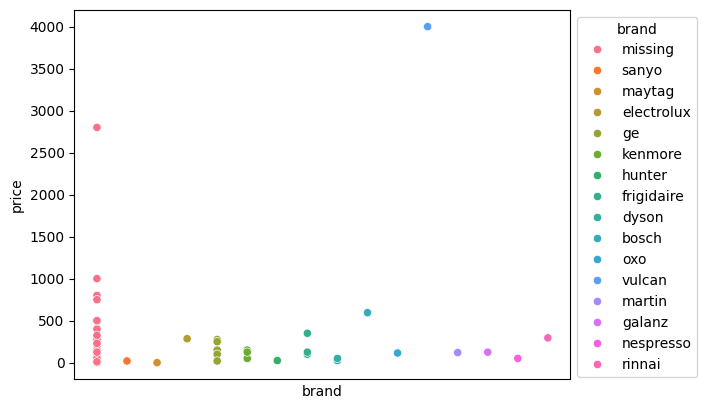

In [21]:
ax = sns.scatterplot(data=df, x='brand', y='price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xticks([])

([], [])

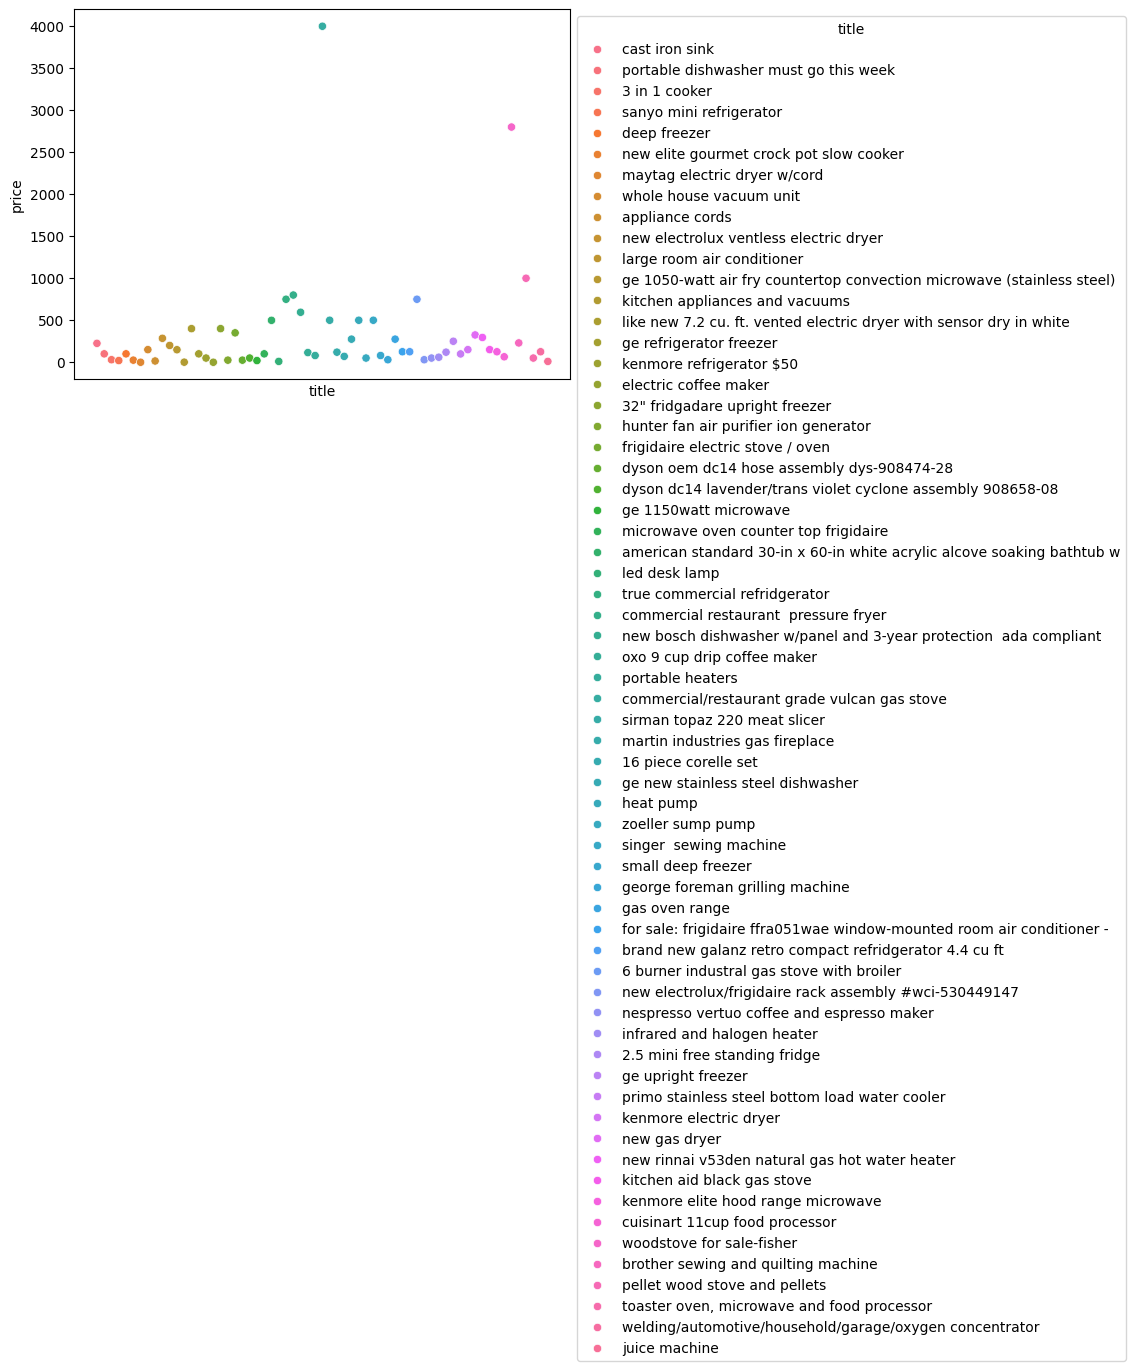

In [24]:
ax = sns.scatterplot(data=df, x='title', y='price',hue='title')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xticks([])

From the data wrangling and plots created above, I have drawn several conclusions. First, from the Price Histogram we see that the majority of appliances on Craigslist fall into the 0-500 dollar range. I found this initially surprising, as I imagine many appliances are priced greater than 500 dollars. They may be cheaper given the second-hang nature of Craigslist. Next, from the Brand Histogram we see that GE and Fridgidaire are the most common appliance brands being sold at the moment. The Price by Brand Scatterplot shows us that the single count of Vulcan appliance is an outlier, priced much higher than any other appliance by brand. From outside research I see that Vulcan products are industrial and very high price (30,000 dollar average), explaining this outlier. Additionally, the plot showed that brands such as Electrolux and GE tended to have lower priced items compared to brands such as Bosch, although the difference is very minimal. Lastly, the Price by Title Scatterplot showed visual insights on what products were being sold compared to their price. We can see that there was a fairly even spread of products and prices.